## Introduction

For this project, we are going to utilize the machine learning algorithms to analyze the Spotify dataset. https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks 

First, we will do data visualization on the dataset. 

Then, we will predict the popularity of songs based on different features. 

Moreover, we are going to cluster different genres according to audio features. 

### About the data

Responsible Variable - y 

**pularity:**~100 int 0:least popluar, 100:most popluar 

Independent Variables - x 

**Acousticness:**
A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
1.0 represents high confidence the track is acoustic.

**danceability:**
Danceability describes how suitable a track is for dancing based on a combination of musical elements. A value of 0.0 is least danceable and 1.0 is most danceable.

**energy:**
A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.

**explicit:** 
Whether or not the track has explicit lyrics ( true = yes it does 1 ; false = no it does not OR unknown 0).

**id:** 
The Spotify ID for the track

**instrumentalness:**
The relative ratio of the track being instrumental

**key:**
primary key of the track 

**liveness:**
The relative duration of the track sounding as a live performance.A value above 0.8 provides strong likelihood that the track is live.

**loudness:**
Relative loudness of the track in the typical range [-60, 0] in decibel (dB)

**mode:**
whether the track starts with a major (1) chord progression or not (0)

**name:**
the name of the track 

**release_date:** #drop this 
The date of release of the track in yyyy-mm-dd, yyyy-mm, or even yyyy format

**speechiness:**
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

**tempo:**
The overall estimated tempo of a track in beats per minute (BPM).

**valence:**
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive

**year:**
the year of the track released 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer # For text mining
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder # Need to use it for year
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression # Logistic 
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest

from sklearn.cluster import KMeans # Clustering analysis
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE # Make graph for clusters
import matplotlib.patheffects as PathEffects

from sklearn.metrics.pairwise import cosine_similarity # For recommendation enfine

import warnings # Suppress warnings because they are annoying
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data_song = pd.read_csv("data.csv")
data_song.head(1) #169909 rows × 17 columns

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.195,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.151,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.779,1928


In [3]:
data_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

# Part I: Feature Exploration

In [4]:
# We want to keep the numerical data first, release date are similar to year, so we only keep year
data_song = data_song.drop(['artists', 'id', 'release_date'],axis=1)

<AxesSubplot:>

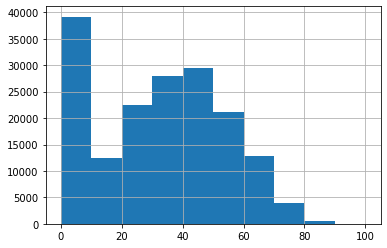

In [5]:
# Check the distribution of popularity
data_song['popularity'].hist()

In [6]:
# Label the popularity - we use 30 as our cut-off point, to balance the total number of 0 and 1
data_song.loc[data_song['popularity'] <= 30, 'Target'] = 0  #less popular
data_song.loc[data_song['popularity'] > 30, 'Target'] = 1 #more popular 

In [7]:
# The dataset for the prediction model
data_song.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,Target
0,0.995,0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,0.0506,118.469,0.7790,1928,0.0
1,0.994,0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,0.0462,83.972,0.0767,1928,0.0
2,0.604,0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,0.9290,107.177,0.8800,1928,0.0
3,0.995,0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,0.0926,108.003,0.7200,1928,0.0
4,0.990,0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,0.0424,62.149,0.0693,1928,0.0


In [8]:
# Define X and y
X = data_song.select_dtypes(include=['int64','float64']) # all numerical data
X = X.drop(['popularity','Target'], axis=1) # Delete popularity
y = data_song['Target']

In [9]:
# Try to have a balanced data
y.value_counts()

1.0    93185
0.0    76724
Name: Target, dtype: int64

<AxesSubplot:>

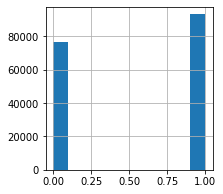

In [10]:
# Plot y variable
data_song['Target'].hist(figsize=(3,3))

<function matplotlib.pyplot.show(close=None, block=None)>

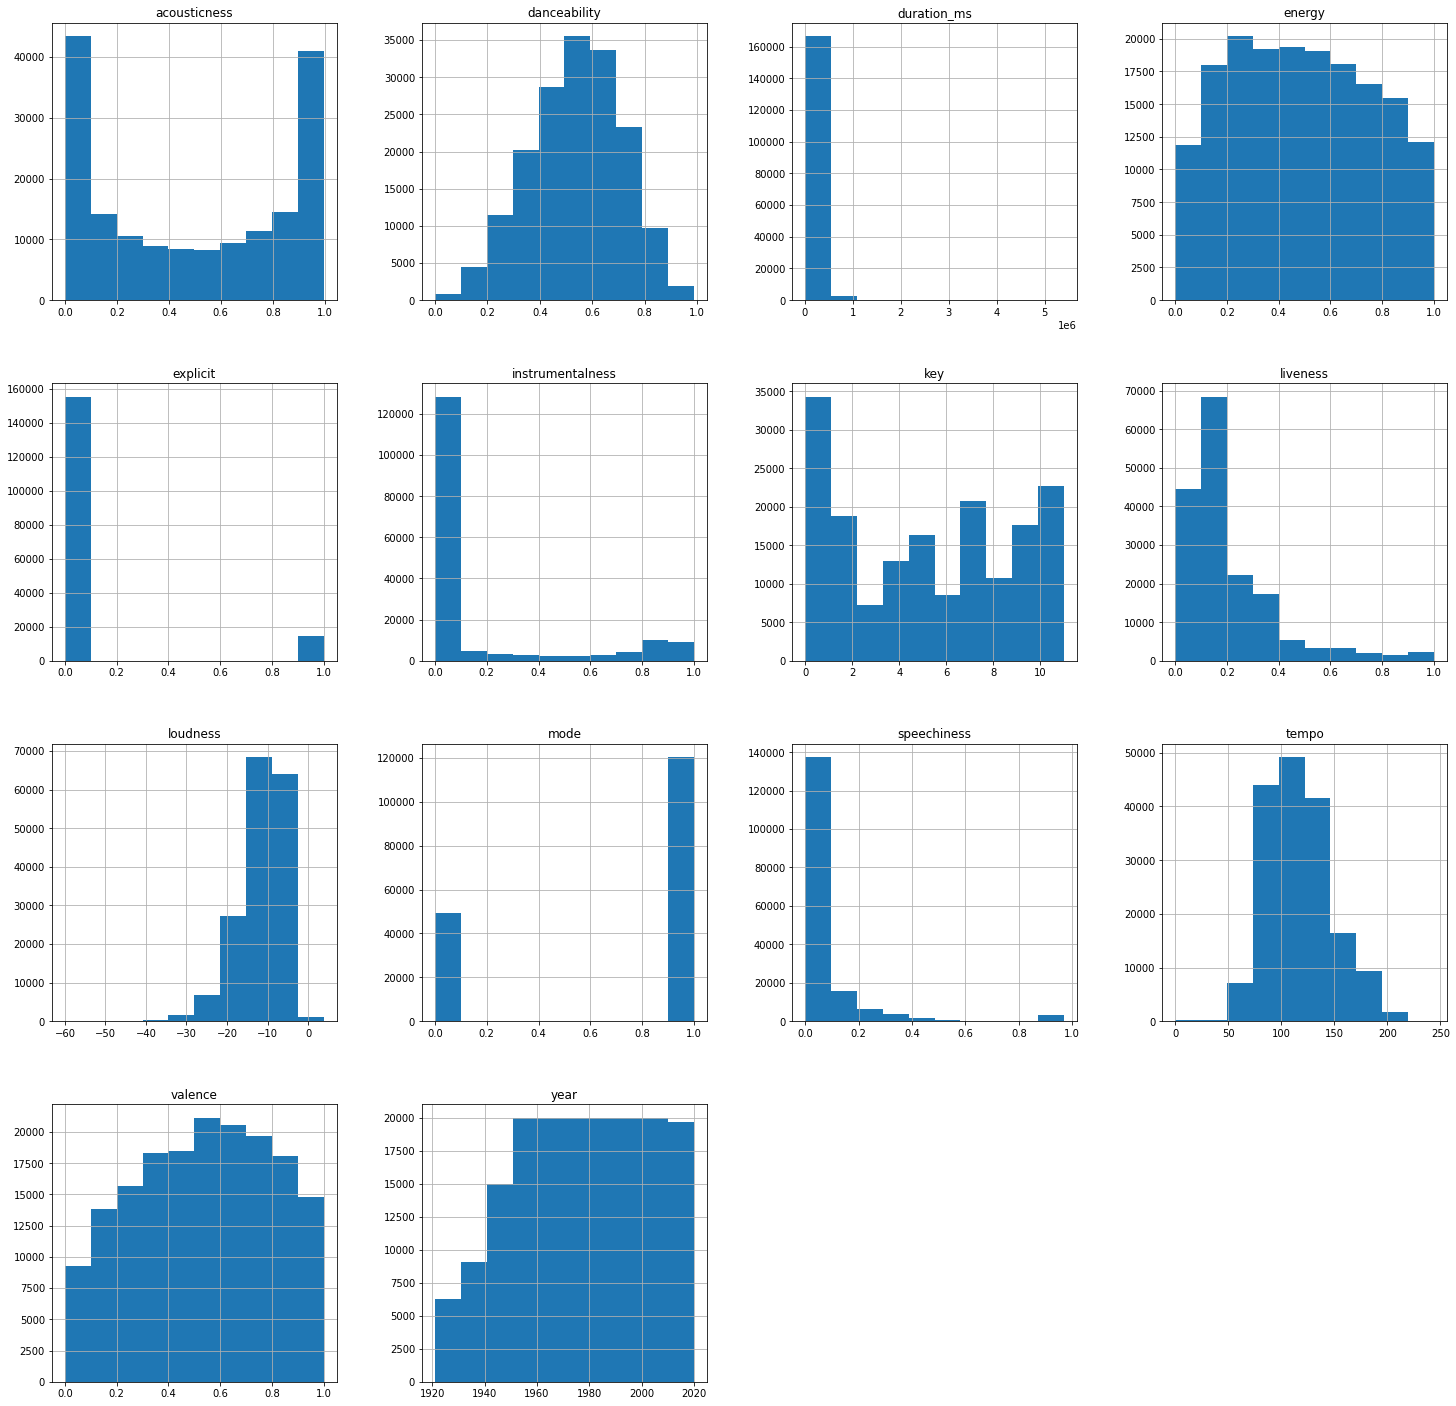

In [11]:
# Check all the x variables
X.hist(figsize=(25,25))
plt.show

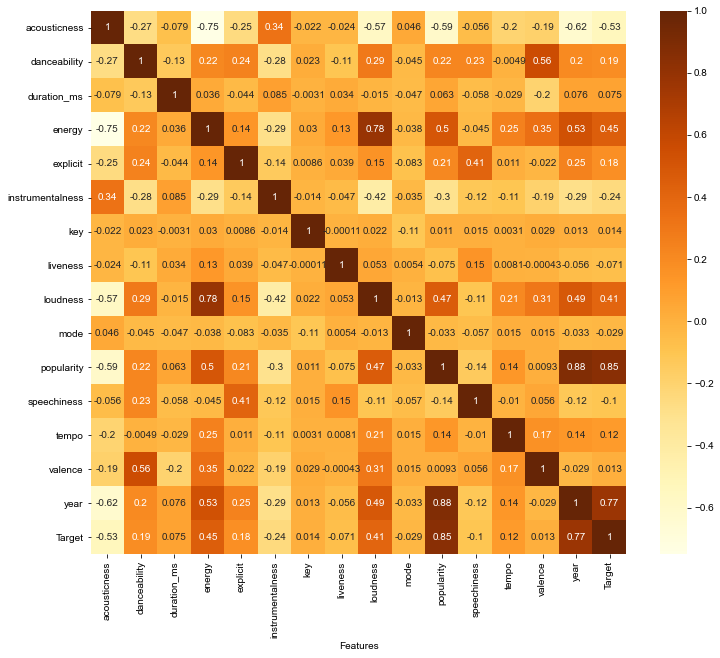

In [12]:
# Heatmap
f,ax = plt.subplots(figsize = (12,10)) #the size of the heat map
sns.heatmap(data_song.corr(), annot = True, fmt = '.2g', cmap = 'YlOrBr', ax= ax)
sns.set(font_scale = 0.75) #the font size of the value in the heat map
plt.xlabel('Features')
plt.show()

In [13]:
# Check the performance between years
year_avg = data_song[['danceability','energy','liveness','acousticness', 'valence','year','loudness'
                     ]].groupby('year').mean().sort_values(by='year').reset_index()
year_avg.head()

,year,danceability,energy,liveness,acousticness,valence,loudness
0,1921,0.425661,0.236784,0.215814,0.895823,0.425495,-17.095438
1,1922,0.480000,0.237026,0.238647,0.939236,0.534056,-19.179958
2,1923,0.568462,0.246936,0.236656,0.976329,0.624788,-14.373882
3,1924,0.548654,0.347033,0.237875,0.935575,0.668574,-14.202304
4,1925,0.571890,0.264373,0.243094,0.965422,0.616430,-14.516707


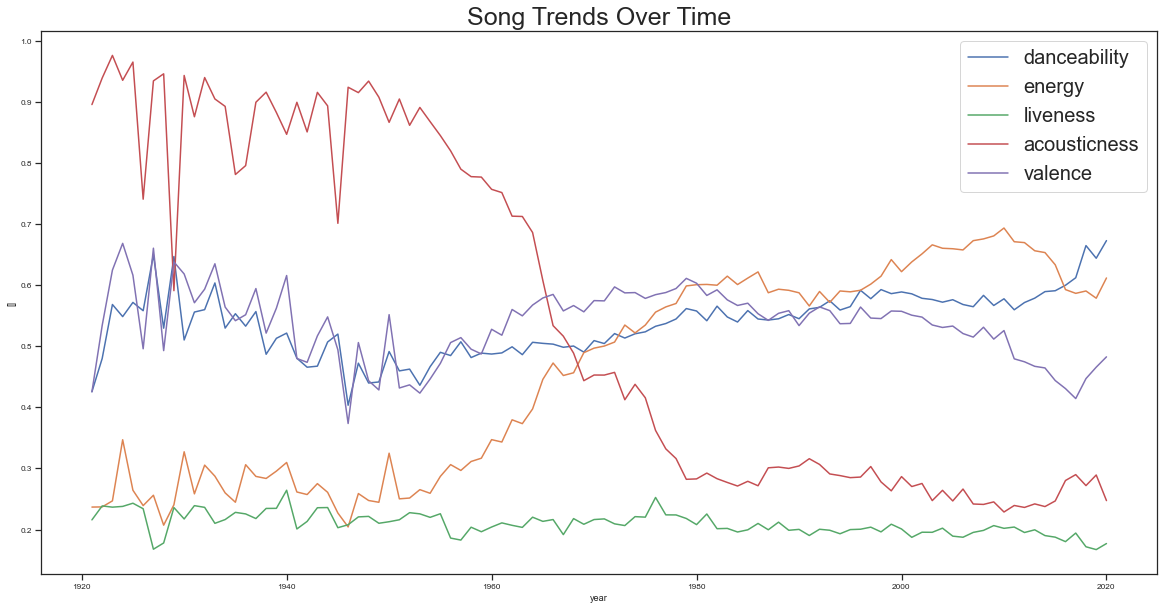

In [14]:
# Generate line chart for those five features (value 0 to 1) between different years
sns.set_style("ticks")
plt.figure(figsize=(20,10))
plt.title("Song Trends Over Time", fontsize=25)
lines = ['danceability','energy','liveness','acousticness','valence']
for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
plt.ylabel([ ])
plt.legend(lines,fontsize=20)

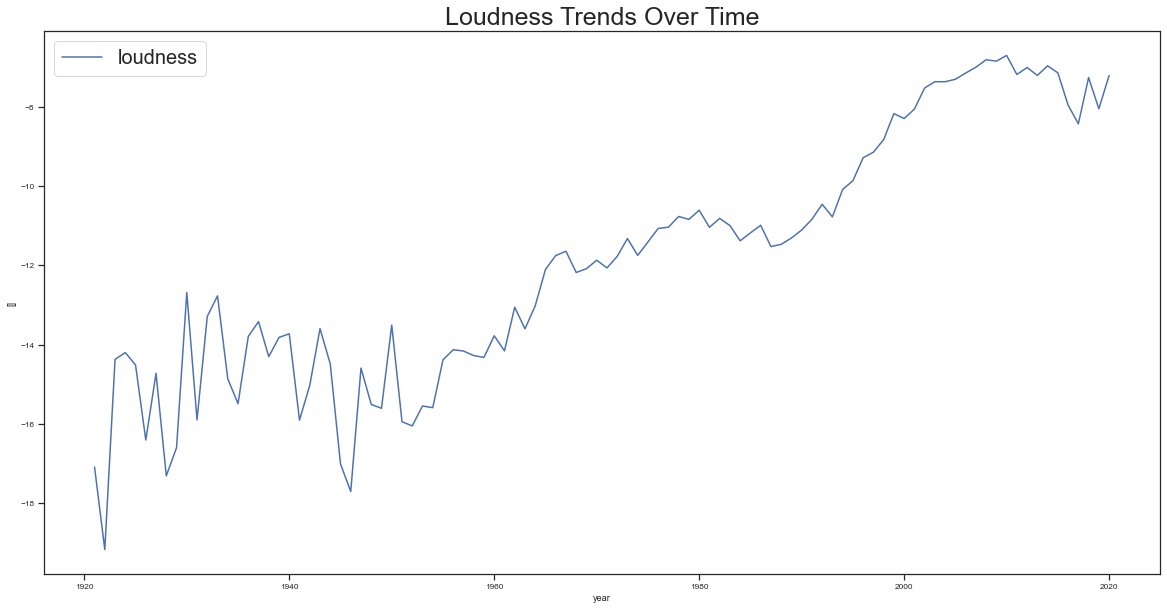

In [15]:
# Loudness trend (value -60 to 0)
plt.figure(figsize=(20,10))
plt.title("Loudness Trends Over Time", fontsize=25)
lines = ['loudness']
for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
plt.ylabel([ ])
plt.legend(lines,fontsize=20)

<Figure size 1080x1080 with 0 Axes>

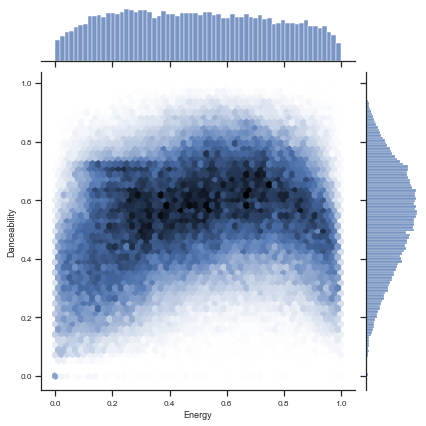

In [16]:
# Relationship between energy and dancebility
plt.figure(figsize=(15,15))
sns.jointplot(x='energy',y='danceability',data=data_song[['energy','danceability']],kind ="hex").set_axis_labels('Energy','Danceability')

## Text Mining

### Overall Performance

In [17]:
# Initialize the CountVectorizer
count_vect = CountVectorizer(stop_words = 'english', 
                             token_pattern = r'\b[^\d\W]+\b', 
                             analyzer='word', ngram_range=(1, 1), 
                             min_df = 1500)
# Run the CountVectorizer on the text
name_bag_o_words = count_vect.fit_transform(data_song['name']) 
name_bag_o_words.shape

(169909, 25)

In [18]:
# Most frequency words shows in song's name
print(count_vect.get_feature_names())

['act', 'allegro', 'blues', 'd', 'don', 'el', 'feat', 'ii', 'la', 'live', 'love', 'm', 'major', 'man', 'minor', 'op', 'remaster', 'remastered', 'remasterizado', 's', 'song', 't', 'time', 'version', 'часть']


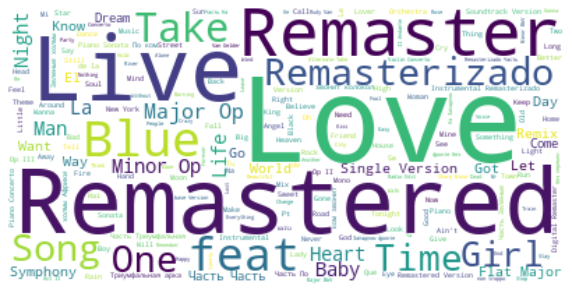

In [19]:
# Generate a word cloud image
text = " ".join(text for text in data_song.name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image, the matplotlib way
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Keywords with low popularity

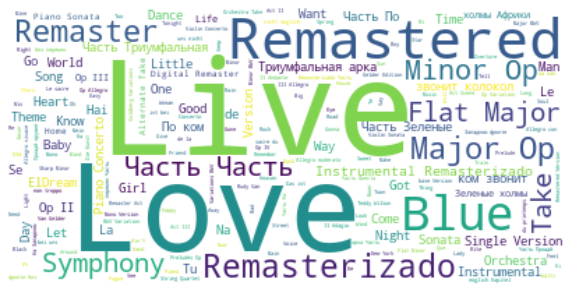

In [20]:
data_song_t0 = data_song[data_song['Target']==0] # Select target equals 0

# Generate a word cloud image
text = " ".join(text for text in data_song_t0.name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image, the matplotlib way
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Keywords with high popularity

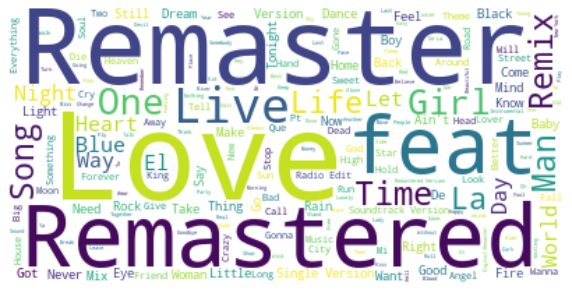

In [21]:
data_song_t1 = data_song[data_song['Target']==1] # Select target equals 1

# Generate a word cloud image
text = " ".join(text for text in data_song_t1.name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image, the matplotlib way
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# PART II: Classficaiton Models

In [22]:
# Encode the year column to be categorical
X['year'] = LabelEncoder().fit_transform(X['year'])

# Split data into 80% - 20% train / test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Scale the data
scaler = StandardScaler()
X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

In [23]:
# Define the individual models
LR = LogisticRegression()
GB = GaussianNB()
DT = DecisionTreeClassifier(random_state=123) 
RF1 = RandomForestClassifier(n_estimators=50, random_state=123)
RF2 = RandomForestClassifier(max_features=8, random_state=123)

# Fit the voting classifier
vc_soft = VotingClassifier(estimators = [('LR', LR), ('GB', GB), ('DT', DT), 
                                    ('RF1', RF1), ('RF2', RF2)], n_jobs = 2, voting='soft')
# Fit the model
vc_soft.fit(X_trainS, y_train)

# Prediction on test set
print('Voting soft:', accuracy_score(vc_soft.predict(X_testS), y_test))

Voting soft: 0.8618091931022306


In [24]:
# Evaluation (accuracy) on the test set -- individual models
LR.fit(X_trainS, y_train)
GB.fit(X_trainS, y_train)
DT.fit(X_trainS, y_train)
RF1.fit(X_trainS, y_train)
RF2.fit(X_trainS, y_train)
print('Logistic Regression:', accuracy_score(LR.predict(X_testS), y_test))
print('Gaussian Naive Bayes:', accuracy_score(GB.predict(X_testS), y_test))
print('Decision Tree:', accuracy_score(DT.predict(X_testS), y_test))
print('RandomForest 1:', accuracy_score(RF1.predict(X_testS), y_test))
print('RandomForest 2:', accuracy_score(RF2.predict(X_testS), y_test))

Logistic Regression: 0.8638102524866106
Gaussian Naive Bayes: 0.8276440468483315
Decision Tree: 0.8252015773056324
RandomForest 1: 0.8673121064092755
RandomForest 2: 0.869018892354776


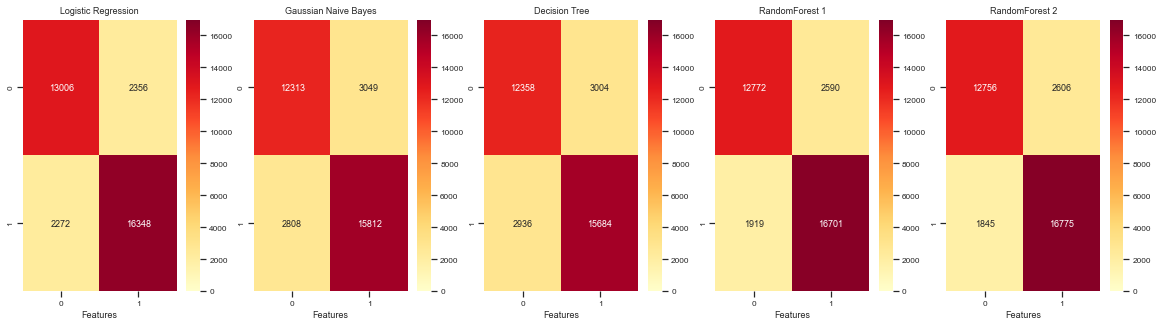

In [25]:
# Create the confusion matrix table for the performance of model

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize = (20,5))
#1. Logistic Regression
LogregCM = confusion_matrix(y_test, LR.predict(X_testS))
sns.heatmap(LogregCM, annot = True, fmt = 'd', vmin = 0, vmax = 17000, cmap = 'YlOrRd', ax = ax1)
#Annot: the value of the heatmap
#fmt: the decimal point of value of heatmap
#vmin, vmax: the limits of the colorbar
ax1.set_title('Logistic Regression')
ax1.set_xlabel('Features')

#2. Gaussian Naive Bayes
NBCM = confusion_matrix(y_test, GB.predict(X_testS))
sns.heatmap(NBCM, annot = True, fmt = 'd', vmin = 0, vmax = 17000, cmap = 'YlOrRd', ax = ax2)
ax2.set_title('Gaussian Naive Bayes')
ax2.set_xlabel('Features')

#3. Decision Tree
DTCM = confusion_matrix(y_test, DT.predict(X_testS))
sns.heatmap(DTCM, annot = True, fmt = 'd', vmin = 0, vmax = 17000, cmap = 'YlOrRd', ax = ax3)
ax3.set_title('Decision Tree')
ax3.set_xlabel('Features')

#4. Random Forest1
RandomForest1CM = confusion_matrix(y_test, RF1.predict(X_testS))
sns.heatmap(RandomForest1CM, annot = True, fmt = 'd', vmin = 0 , vmax = 17000, cmap = 'YlOrRd', ax = ax4)
ax4.set_title('RandomForest 1')
ax4.set_xlabel('Features')

#5. Random Forest2
RandomForest2CM = confusion_matrix(y_test, RF2.predict(X_testS))
sns.heatmap(RandomForest2CM, annot = True, fmt = 'd', vmin = 0 , vmax = 17000, cmap = 'YlOrRd', ax = ax5)
ax5.set_title('RandomForest 2')
ax5.set_xlabel('Features')

plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

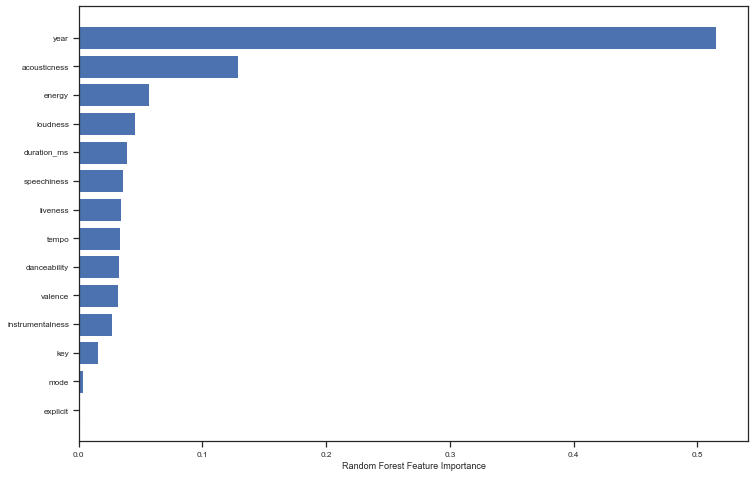

In [26]:
# Check the feature importance for the best model (RF2)
sorted_idx = RF2.feature_importances_.argsort()
plt.figure(figsize=(12,8))
plt.barh(X.columns[sorted_idx], RF2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Year is the most important feature in predicting the popularity. 

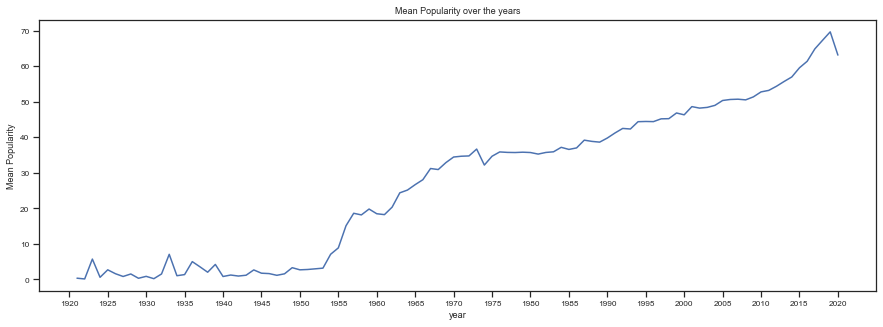

In [27]:
# Check the mean popularity between different years
fig, ax = plt.subplots(figsize=(15, 5))
ax = data_song.groupby('year')['popularity'].mean().plot()
ax.set_title('Mean Popularity over the years')
ax.set_ylabel('Mean Popularity')
ax.set_xticks(range(1920, 2021, 5))
plt.show()

### Are certain keys more popular than others?

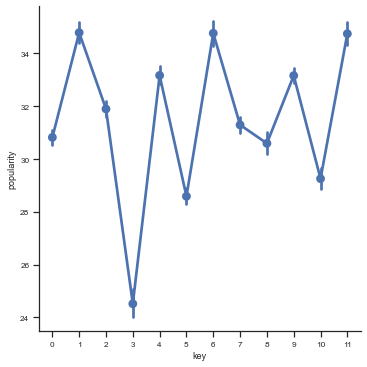

In [28]:
# Key vs Popularity
sns.factorplot('key','popularity', data = data_song)

### Are songs in major keys more popular?
Songs in a major key generally sound happier, while songs in a minor key are more melancholy. Does this have an effect on popularity?

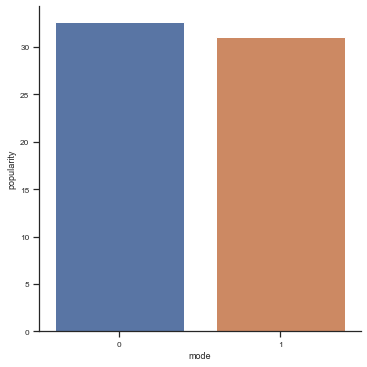

In [29]:
# Mode vs Popularity 
mode = data_song[['popularity', 'mode']].groupby('mode').mean().reset_index()
sns.catplot(data=mode, kind="bar", x='mode', y="popularity")

In [30]:
mode # See the average of popularity between 2 mode

,mode,popularity
0,0,32.662210
1,1,31.101852


### Are short songs more popular than long ones?

In [31]:
# Create bins — 
# 0–0:59 = very short,1:00-1:59 = short 2:00–3:59 = medium, 4:00–5:59 = long,  >=6:00 = very long
song = data_song[['popularity', 'duration_ms']]
# Create a seconds column
song['duration_ms'] = song['duration_ms'].apply(lambda div: div / 1000)
# Group durations into categorical var column 'Length'
bin_names = ['very short','short', 'medium', 'long','very Long']
bin_numbers = [0, 59, 119, 239, 359, 999999999]
song['length'] = pd.cut(song['duration_ms'], bins = bin_numbers, labels = bin_names)
song.head()

,popularity,duration_ms,length
0,0,158.648,medium
1,0,282.133,long
2,0,104.300,short
3,0,180.760,medium
4,1,687.733,very Long


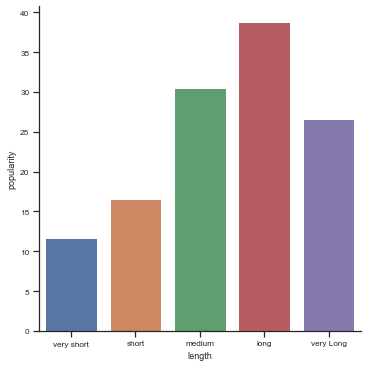

In [32]:
# See the popularity between different length of songs
song_length=song[['popularity', 'length']].groupby('length').mean().reset_index()
sns.catplot(data=song_length, kind="bar", x='length', y="popularity")

# PART III:  Clustering

In [33]:
# Load the data
data_genre = pd.read_csv("data_by_genres.csv")
data_genre.head(1) #2664 rows × 14 columns

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,432hz,0.49478,0.299333,1.048887e+06,0.450678,0.477762,0.131,-16.854,0.076817,120.285667,0.22175,52.166667,5,1


In [34]:
# Prepare data for clustering analysis
data = data_genre.copy()
data = data.drop(['genres'], axis=1)
scaler = StandardScaler()
scale_data = scaler.fit_transform(data)
data_s = pd.DataFrame(scale_data)
# Present the data
data_s.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.304949,-1.597132,8.829288,-0.501271,1.083808,-0.714516,-1.297072,-0.086454,0.082030,-1.404830,0.752245,-0.270102,0.431403
1,0.892625,-0.101537,-0.215688,-0.717369,-0.012824,0.315066,-0.461056,0.355823,-0.389399,0.084163,-1.151201,0.319936,0.431403
2,0.708760,0.272420,-0.615465,-0.962797,-0.765721,-0.758992,-0.479306,0.144446,-0.401494,-0.233378,0.201851,1.500011,0.431403
3,-0.126366,-0.518783,1.034055,-0.341596,2.307708,-0.845450,-0.743990,-0.503109,0.336422,-0.983496,0.086224,-1.450177,0.431403
4,-0.145635,1.062722,-0.171825,0.214076,0.582917,-1.038971,0.736275,0.744901,0.031393,0.682790,1.153939,1.204992,-2.318018


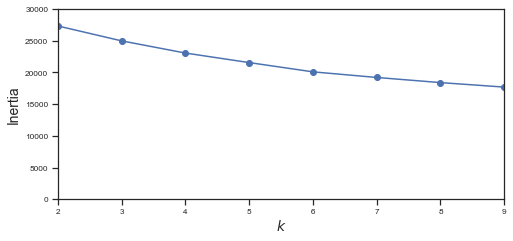

In [35]:
# Run K-Means for various number of clusters. 
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_s)
                for k in range(2, 10)]

# Extract the inertia for each model
inertias = [model.inertia_ for model in kmeans_per_k]

# Plot the inertia
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.axis([2, 9, 0, 30000])
plt.show()

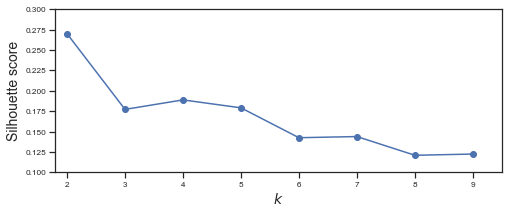

In [36]:
# Calculate the silhouette score for K = 1..10
silhouette_scores = [silhouette_score(data_s, model.labels_)
                     for model in kmeans_per_k[0:]]


plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.1, 0.3])
plt.show()

Looks like we could choose 5 as our k value

In [37]:
# With our selected K value
new_data = KMeans(n_clusters=5, random_state=42).fit(data_s)
new_data.labels_

array([2, 4, 4, ..., 1, 4, 1])

In [38]:
# Prepare for scatter plot of the 5 clusters
label_data=new_data.labels_

### Test if 5 clusters is a good choice for our data

In [39]:
# A good way to make the plot - TSNE 
genres_tsne = TSNE(random_state=42).fit_transform(data_s)

In [40]:
# Ref: https://www.datacamp.com/community/tutorials/introduction-t-sne
# Create a scatter plot function
def genres_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-16.534327, 45.761208, '0'),
  Text(29.911247, -1.4624691, '1'),
  Text(-31.423939, -22.566519, '2'),
  Text(-75.46229, 6.233875, '3'),
  Text(-14.546564, 6.9347134, '4')])

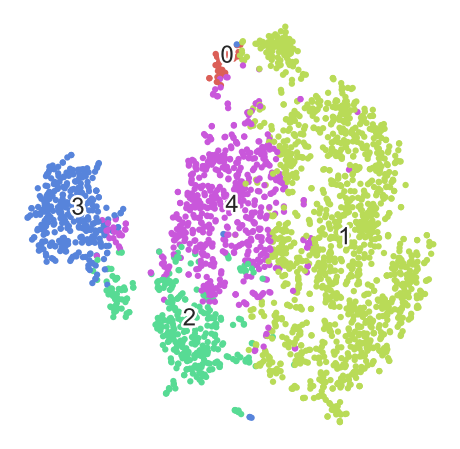

In [41]:
# Generate the graph
genres_scatter(genres_tsne, label_data)

In [42]:
# Check the performance of different clusters
data_agg = pd.concat([data, pd.DataFrame({'cluster':new_data.labels_})], axis=1)
data_agg.groupby('cluster').mean()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
cluster,,,,,,,,,,,,,
0,0.718922,0.611806,311855.339773,0.383781,0.035371,0.312087,-15.463545,0.616567,110.250612,0.516410,16.188509,6.468750,0.781250
1,0.197856,0.568598,246508.460803,0.698905,0.139725,0.195205,-7.693435,0.085499,123.698536,0.524143,47.184845,6.007262,1.000000
2,0.833267,0.334015,305830.800969,0.210789,0.575361,0.170556,-19.757313,0.051716,103.914239,0.234219,31.628584,5.170520,0.841040
3,0.235661,0.592219,252932.135996,0.677778,0.143475,0.183818,-7.960070,0.082914,124.018261,0.533705,47.086601,6.544073,0.000000
4,0.692758,0.545578,217075.488170,0.403061,0.160433,0.203768,-12.240984,0.069768,113.783923,0.577960,25.777036,5.755172,0.953448


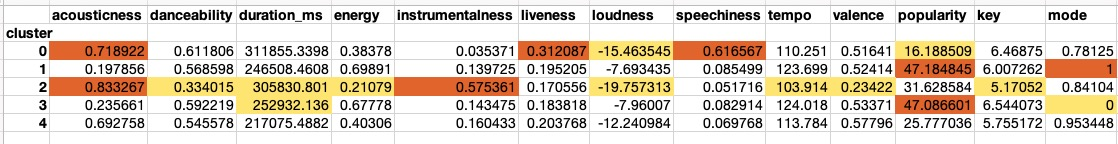

### Which genres appear in different groups?

In [43]:
# Check the genres with labels
data_genre_agg = pd.concat([data_genre, pd.DataFrame({'cluster':new_data.labels_})], axis=1)
data_genre_agg.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,cluster
0,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.166667,5,1,2
1,[],0.679245,0.521473,2.298526e+05,0.401522,0.196737,0.221586,-12.679076,0.112267,112.025168,0.515920,21.682005,7,1,4
2,a cappella,0.621532,0.577017,1.936522e+05,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,43.351819,11,1,4
3,abstract,0.359395,0.459500,3.430185e+05,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,41.500000,1,1,2
4,abstract beats,0.353347,0.694400,2.338244e+05,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,58.600000,10,0,3


In [44]:
# Check the genre name after with 5 clusters
cluster0 = data_genre_agg.loc[data_genre_agg['cluster'] == 0, 'genres']
cluster1 = data_genre_agg.loc[data_genre_agg['cluster'] == 1, 'genres']
cluster2 = data_genre_agg.loc[data_genre_agg['cluster'] == 2, 'genres']
cluster3 = data_genre_agg.loc[data_genre_agg['cluster'] == 3, 'genres']
cluster4 = data_genre_agg.loc[data_genre_agg['cluster'] == 4, 'genres']
c1 = pd.DataFrame(cluster0.head(20)).reset_index()
c2 = pd.DataFrame(cluster1.head(20)).reset_index()
c3 = pd.DataFrame(cluster2.head(20)).reset_index()
c4 = pd.DataFrame(cluster3.head(20)).reset_index()
c5 = pd.DataFrame(cluster4.head(20)).reset_index()
pd.concat([c1,c2,c3,c4,c5], axis=1)

,index,genres,index,genres,index,genres,index,genres,index,genres
0,218,beat poetry,5,abstract hip hop,0,432hz,4,abstract beats,1,[]
1,219,beatboxing,8,acid house,3,abstract,21,african percussion,2,a cappella
2,252,black comedy,9,acid jazz,12,acousmatic,32,afrofuturismo brasileiro,6,accordeon
3,302,brazilian punk rock,10,acid rock,57,ambient,34,afroswing,7,accordion
4,463,children's story,11,acid trance,62,ambient pop,39,albanian pop,13,acoustic blues
5,590,clean comedy,14,acoustic pop,64,ambient worship,41,alberta hip hop,17,adult standards
6,600,comedy,15,acoustic punk,65,american choir,56,ambeat,18,adventista
7,726,deep comedy,16,adoracion,66,american contemporary classical,63,ambient techno,20,african gospel
8,811,drama,19,afghan pop,69,american modern classical,68,american metalcore,30,afrobeat brasileiro
9,837,dutch cabaret,22,african reggae,70,american post-rock,74,anadolu rock,59,ambient folk


# PART IV: Recommendation Engine

## Use the item attribution to provide recommendation

In [45]:
# Load the data
rate = pd.read_csv("SpotifyRating.csv")
rate['genres'] = rate['genres'].str.replace("^\[|\]$","")
rate['genres'] = rate['genres'].str.replace("'", '')

# Replace missing values with 0
rate = rate.fillna(0)

rate.head(5) #380 rows × 4 columns

,artists,User1,User2,genres
0,SuicideBoys,2.0,0.0,"dark trap, new orleans rap, underground hip hop"
1,(G)I-DLE,3.0,5.0,"k-pop, k-pop girl group"
2,22Gz,2.0,0.0,nyc rap
3,5 Seconds of Summer,4.0,3.0,"boy band, dance pop, pop, post-teen pop"
4,645AR,1.0,0.0,meme rap


In [46]:
# Create a dataframe using artists as index - prepare for cosine similarity
rate2 = rate.copy()
rate2.set_index("artists", inplace = True)
rate2

,User1,User2,genres
artists,,,
SuicideBoys,2.0,0.0,"dark trap, new orleans rap, underground hip hop"
(G)I-DLE,3.0,5.0,"k-pop, k-pop girl group"
22Gz,2.0,0.0,nyc rap
5 Seconds of Summer,4.0,3.0,"boy band, dance pop, pop, post-teen pop"
645AR,1.0,0.0,meme rap
...,...,...,...
girl in red,0.0,3.0,"bedroom pop, indie pop, norwegian indie, pop"
iann dior,0.0,0.0,"melodic rap, pop rap"
jxdn,0.0,0.0,social media pop


In [47]:
# Extract the genres
genres = rate2['genres'].str.get_dummies(',')
genres.head()

,atl hip hop,atl trap,australian pop,bedroom soul,bergen indie,blues rock,brostep,calming instrumental,canadian contemporary country,canadian contemporary r&b,...,pop rap,r&b en espanol,rap,regional mexican pop,sertanejo universitario,sleep,social media pop,texas country,trap,vapor trap
artists,,,,,,,,,,,,,,,,,,,,,
SuicideBoys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(G)I-DLE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22Gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5 Seconds of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645AR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Calculate the cosine similarity of the artist (based on genres)
genres_sim = cosine_similarity(genres)
genres_sim = pd.DataFrame(genres_sim, index = genres.index, columns = genres.index)

In [49]:
# Function that take the artist name and return the top n recommendations
def print_recommendations(original_item, top_n):
    idx = original_item
    print("Your original artist is", rate[rate['artists'] == str(idx)]['artists'].values)
    recommends = genres_sim.loc[str(idx)].sort_values(ascending = False)[1:].index
    for i in range(top_n):
        rec_artist = recommends[i]
        print("My number ", i+1, " recommendation artist is ", rate[rate['artists'] == rec_artist]['artists'].values)

In [50]:
# Let's see what the recommendation output, use BTS as our oiginal artist
print_recommendations('BTS', 10)

Your original artist is ['BTS']
My number  1  recommendation artist is  ['BTS']
My number  2  recommendation artist is  ['GOT7']
My number  3  recommendation artist is  ['Monsta X']
My number  4  recommendation artist is  ['NCT 127']
My number  5  recommendation artist is  ['NCT DREAM']
My number  6  recommendation artist is  ['TOMORROW X TOGETHER']
My number  7  recommendation artist is  ['CHUNG HA']
My number  8  recommendation artist is  ['BAEKHYUN']
My number  9  recommendation artist is  ['TWICE']
My number  10  recommendation artist is  ['ITZY']


## Use the user rating profile to provide recommendation

- User1 - Yu Han

In [51]:
# First, we extract the rating matrix of user id 1
user_rating = rate[['User1']]
user_rating=user_rating.transpose()

In [52]:
# Rename columns with artists name 
user_rating.columns=rate['artists']
user_rating

artists,SuicideBoys,(G)I-DLE,22Gz,5 Seconds of Summer,645AR,6LACK,6ix9ine,A Boogie Wit da Hoodie,A Day To Remember,A$AP Ferg,...,Zion & Lennox,blackbear,boy pablo,chillchild,dvsn,girl in red,iann dior,jxdn,keshi,mike.
User1,2.0,3.0,2.0,4.0,1.0,3.0,3.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Now let's create the weighted attribute matrix for the artists the user has watched
weighted_attribute = pd.DataFrame(columns = genres.columns)
listened = np.where(user_rating.iloc[0,:] != 0)[0] # Which artists did the user rated
artist_id = user_rating.columns[listened] # The IDs of the rated artists
for i in range(len(listened)):
    ID = artist_id[i]
    scores = np.array(user_rating.iloc[:,listened[i]]) * np.array(genres.loc[ID,:]) # Calculate the weighted attributes
    scores = pd.DataFrame(scores).T # Convert the result from array to dataframe
    scores.columns = genres.columns # Attach column names to the dataframe
    weighted_attribute = weighted_attribute.append(scores)

weighted_attribute.index = artist_id # Add the artist indices to the dataframe

In [54]:
# This is what the weighted attribute looks like
weighted_attribute.head() 

,atl hip hop,atl trap,australian pop,bedroom soul,bergen indie,blues rock,brostep,calming instrumental,canadian contemporary country,canadian contemporary r&b,...,pop rap,r&b en espanol,rap,regional mexican pop,sertanejo universitario,sleep,social media pop,texas country,trap,vapor trap
artists,,,,,,,,,,,,,,,,,,,,,
SuicideBoys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22Gz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 Seconds of Summer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
645AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Next we will create the scaled attribute score
scaled_attribute = np.sum(weighted_attribute, axis = 0)/ np.sum(np.sum(weighted_attribute))

In [56]:
# Now for each unlistened artist, calculate the weighted rating 
# Remove watched movies from the movie attribute matrix
artist_drop = genres.drop(index = map(str, artist_id))

# Calculate the weighted rating
weighted_rating = artist_drop.mul(scaled_attribute, axis=1)

# And get the overall rating for each movie
new_ratings = np.sum(weighted_rating, axis = 1)

In [57]:
# Sort the new ratings in descending order
nr = new_ratings.sort_values(ascending = False)

# Print the recommendation for user 1
result = pd.DataFrame(nr.head(10)).reset_index().rename(columns={0:"Predicted Rating"})
result['Recommendation number for user 1'] = range(1,11)
result = result[['Recommendation number for user 1','artists','Predicted Rating']]
result

,Recommendation number for user 1,artists,Predicted Rating
0,1,T-Pain,0.272803
1,2,The Pussycat Dolls,0.251658
2,3,Tove Lo,0.231343
3,4,Sean Kingston,0.208955
4,5,Troye Sivan,0.204395
5,6,Taylor Swift,0.199834
6,7,Selena Gomez,0.199834
7,8,Sean Paul,0.181177
8,9,Trey Songz,0.176202
9,10,Russ,0.169154


- User2 - Di Wang

In [58]:
# Next, we extract the rating matrix of user id 2
user_rating = rate[['User2']]
user_rating=user_rating.transpose()

# Rename columns with artists name 
user_rating.columns=rate['artists']
user_rating

artists,SuicideBoys,(G)I-DLE,22Gz,5 Seconds of Summer,645AR,6LACK,6ix9ine,A Boogie Wit da Hoodie,A Day To Remember,A$AP Ferg,...,Zion & Lennox,blackbear,boy pablo,chillchild,dvsn,girl in red,iann dior,jxdn,keshi,mike.
User2,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0


In [59]:
# Now let's create the weighted attribute matrix for the artists the user has watched
weighted_attribute = pd.DataFrame(columns = genres.columns)
listened = np.where(user_rating.iloc[0,:] != 0)[0] # Which artists did the user rated
artist_id = user_rating.columns[listened] # The IDs of the rated artists
for i in range(len(listened)):
    ID = artist_id[i]
    scores = np.array(user_rating.iloc[:,listened[i]]) * np.array(genres.loc[ID,:]) # Calculate the weighted attributes
    scores = pd.DataFrame(scores).T # Convert the result from array to dataframe
    scores.columns = genres.columns # Attach column names to the dataframe
    weighted_attribute = weighted_attribute.append(scores)

weighted_attribute.index = artist_id # Add the artist indices to the dataframe

# Next we will create the scaled attribute score
scaled_attribute = np.sum(weighted_attribute, axis = 0)/ np.sum(np.sum(weighted_attribute))

# Now for each unlistened artist, calculate the weighted rating 
# Remove watched movies from the movie attribute matrix
artist_drop = genres.drop(index = map(str, artist_id))

# Calculate the weighted rating
weighted_rating = artist_drop.mul(scaled_attribute, axis=1)

# And get the overall rating for each movie
new_ratings = np.sum(weighted_rating, axis = 1)

In [60]:
# Sort the new ratings in descending order
nr = new_ratings.sort_values(ascending = False)

# Print the recommendation
result2 = pd.DataFrame(nr.head(10)).reset_index().rename(columns={0:"Predicted Rating"})
result2['Recommendation number for user 2'] = range(1,11)
result2= result2[['Recommendation number for user 2','artists','Predicted Rating']]
result2

,Recommendation number for user 2,artists,Predicted Rating
0,1,T-Pain,0.306544
1,2,Cheat Codes,0.265212
2,3,Kelly Clarkson,0.243398
3,4,Ellie Goulding,0.243398
4,5,Kelly Rowland,0.238806
5,6,Tove Lo,0.235362
6,7,FLETCHER,0.235362
7,8,MARINA,0.235362
8,9,Halsey,0.234214
9,10,6LACK,0.233065


In [61]:
# Print the result for user1 and user2
final_result= pd.concat([result, result2,], axis=1, sort=False)
final_result

,Recommendation number for user 1,artists,Predicted Rating,Recommendation number for user 2,artists,Predicted Rating
0,1,T-Pain,0.272803,1,T-Pain,0.306544
1,2,The Pussycat Dolls,0.251658,2,Cheat Codes,0.265212
2,3,Tove Lo,0.231343,3,Kelly Clarkson,0.243398
3,4,Sean Kingston,0.208955,4,Ellie Goulding,0.243398
4,5,Troye Sivan,0.204395,5,Kelly Rowland,0.238806
5,6,Taylor Swift,0.199834,6,Tove Lo,0.235362
6,7,Selena Gomez,0.199834,7,FLETCHER,0.235362
7,8,Sean Paul,0.181177,8,MARINA,0.235362
8,9,Trey Songz,0.176202,9,Halsey,0.234214
9,10,Russ,0.169154,10,6LACK,0.233065


ref:

https://www.kaggle.com/j0thu777/spotifyanalysis

Model evaluation, visualization

https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification

时间轴
https://www.kaggle.com/touchinstance/spotify
下拉菜单
https://www.kaggle.com/mayankpagar/do-you-listen-songs-on-spotify-wanna-explore-it/notebook#Most-Popular-Songs-Yearwise